In [24]:
import json, glob, re, os
import matplotlib.pyplot as plt

testNumber = {'0': 2501, '2': 3050, '3': 771, '1': 25} # from dataPreparation
testNumber = [testNumber[str(i)] for i in range(len(testNumber))]
testNumber

[2501, 25, 3050, 771]

In [2]:
out = os.popen("python ../zPackages/map.py -na -dp ../exps/ft_xavier_imagenet_labv2/txt").read()
print(out)

95.66% = 0 AP 
58.23% = 1 AP 
92.18% = 2 AP 
92.03% = 3 AP 
mAP = 84.52%
Figure(640x480)



In [31]:
wmAP = 0
for dataNumber,line in zip(testNumber,out.split("\n")):
    wmAP += dataNumber * float(re.findall("(.*)\%",line)[0]) / sum(testNumber)
wmAP

93.39932881676383

In [13]:
outputDir = "output"
confL = [] # list of confidence within each classes
for path in sorted(glob.glob("./.temp_files/*_dr.json")):
    confL.append( list(map( lambda d:float(d['confidence']), json.load(open(path,'r')) )) )
    print( len(confL[-1]) )

3654
370398
12255
80859


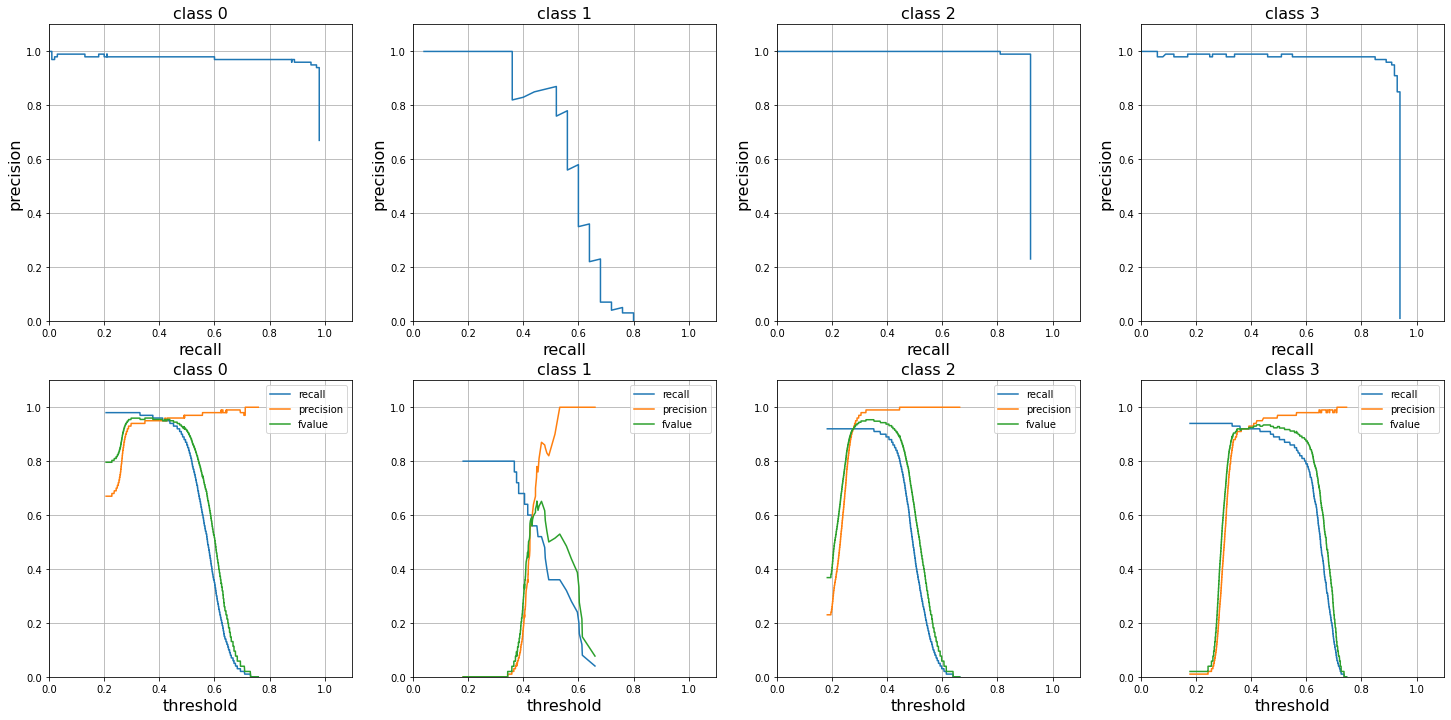

In [26]:
with open(f"{outputDir}/output.txt","r") as f:
    txt = f.read()

bestThresholdL = []
plt.figure(figsize=(25,12))
for i,(recallLine,precisionLine) in enumerate( zip(re.findall("Recall :(.*)",txt),re.findall("Precision: (.*)",txt)) ):
    precisionL = json.loads( precisionLine.replace("\'","") )
    recallL    = json.loads( recallLine.replace("\'","") )
    fvalueL = list(map(lambda j:2/(1/precisionL[j]+1/recallL[j]) if precisionL[j]*recallL[j] else 0, range(len(recallL))))
    _, threshold = max(zip(fvalueL,confL[i]))
    bestThresholdL.append(threshold)
            
    plt.subplot(2,4,i+1)
    plt.plot(recallL, precisionL)
    plt.title(f"class {i}", fontsize=16)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.grid('on')
    
    plt.subplot(2,4,i+5)
    plt.plot(confL[i], recallL)
    plt.plot(confL[i], precisionL)
    plt.plot(confL[i], fvalueL)
    plt.title(f"class {i}", fontsize=16)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(['recall','precision','fvalue'])
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.grid('on')
    
plt.savefig(f"{outputDir}/PR_thres.jpg")
plt.show()

In [33]:
# weighted best threshold
sum(map(lambda tup:tup[0]*tup[1], zip(bestThresholdL,testNumber))) / sum(testNumber)

0.3713070426973373

In [38]:
!python ../zPackages/confusion_matrix.py NPlC,PlC,NPa,Pa 0.37 ../data/labv2/test_map_ant/ ../exps/ft_xavier_imagenet_labv2/txt